In [ ]:
!pip install malariagen_data
!pip install scikit-allel
#!pip install petl

In [ ]:
import malariagen_data
import allel
import numpy as np
import pandas as pd
import functools
from dask.diagnostics.progress import ProgressBar
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
from tqdm.dask import TqdmCallback
from tqdm.auto import tqdm

In [ ]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir 
results_dir = "drive/MyDrive/Fru_paper"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [ ]:
ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release/
Data releases available : 3.0
Results cache           : None
Cohorts analysis        : 20220608
Species analysis        : aim_20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 6.0.1
Client location         : Iowa, US (colab)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see 
https://malariagen.github.io/vector-data/ag3/api.html

In [ ]:
## Selecting and defining the samples metadata
#sets = ['AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-BF-C', 'AG1000G-CI', 'AG1000G-GH', 'AG1000G-GM-A', 
#        'AG1000G-GM-B', 'AG1000G-GM-C', 'AG1000G-GN-A', 'AG1000G-GW',  'AG1000G-ML-A', 'AG1000G-ML-B']
sets = ['AG1000G-AO', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-BF-C', 'AG1000G-CD', 
        'AG1000G-CF','AG1000G-CI', 'AG1000G-CM-A', 'AG1000G-CM-B', 'AG1000G-CM-C', 
        'AG1000G-FR', 'AG1000G-GA-A', 'AG1000G-GH', 'AG1000G-GM-A', 'AG1000G-GM-B', 
        'AG1000G-GM-C', 'AG1000G-GN-A', 'AG1000G-GN-B', 'AG1000G-GW', 
        'AG1000G-KE', 'AG1000G-ML-A', 'AG1000G-ML-B', 'AG1000G-MW', 'AG1000G-MZ', 
        'AG1000G-TZ', 'AG1000G-UG'] 
df_samples = ag3.sample_metadata(sample_sets=sets)

## Acces to the haplotypes 
#df_hap = ag3.haplotypes(region="X", analysis='gamb_colu_arab', sample_sets=sets)


Load sample metadata:   0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
## SNP haplotypes positions 
#pos = allel.SortedIndex(df_hap["variant_position"].values)
#loc_region = pos.locate_range(0,20000000)
#pos_loc = pos[loc_region]
#sel_haps = df_hap.sel(variants = loc_region)
#gt = allel.GenotypeDaskArray(sel_haps['call_genotype'].data)
#gt = allel.GenotypeDaskArray(df_hap['call_genotype'].data)

# Functions to plots garud stats 

From Alistairs



In [ ]:
def load_haps(contig, analysis, sample_query, sample_sets, downsample=30, seed=42):

    # access haplotypes
    ds_haps = ag3.haplotypes(region=contig, sample_query=sample_query, 
                             sample_sets=sample_sets, analysis=analysis)
    pos = ds_haps["variant_position"].values
    gt = allel.GenotypeDaskArray(ds_haps['call_genotype'].data)

    # downsample haplotypes
    n_samples = ds_haps.dims["samples"]
    if n_samples > downsample:
        np.random.seed(seed)
        ix = np.random.choice(n_samples, size=downsample, replace=False)
        ix.sort()
    gt_cohort = gt.take(ix, axis=1)

    # compute haplotypes and load into memory
    with TqdmCallback(desc="Load haplotypes"):
        ht_cohort = gt_cohort.to_haplotypes().compute()
        
    return pos, ht_cohort


In [ ]:
@functools.lru_cache(maxsize=None)
def h12_calibration(contig, analysis, sample_query, window_sizes, sample_sets, downsample=30, seed=42):

    _, ht = load_haps(contig=contig, analysis=analysis, sample_query=sample_query, 
                      sample_sets=sample_sets, downsample=downsample, seed=seed)

    calibration_runs = list()
    for window_size in tqdm(window_sizes, desc="Compute H12"):
        h1, h12, h123, h2_h1 = allel.moving_garud_h(ht, size=window_size)
        calibration_runs.append(h12)

    return calibration_runs

In [ ]:
def plot_h12_calibration(contig, analysis, sample_query, window_sizes, sample_sets, 
                         downsample=30, seed=42, title=None):
    
    # get H12 values
    calibration_runs = h12_calibration(contig=contig, analysis=analysis, sample_query=sample_query, 
                                       sample_sets=sample_sets, window_sizes=window_sizes,
                                       downsample=downsample, seed=seed)

    # compute summaries
    q50 = [np.median(h12) for h12 in calibration_runs]
    q25 = [np.percentile(h12, 25) for h12 in calibration_runs]
    q75 = [np.percentile(h12, 75) for h12 in calibration_runs]
    q05 = [np.percentile(h12, 5) for h12 in calibration_runs]
    q95 = [np.percentile(h12, 95) for h12 in calibration_runs]

    # make a plot
    fig, ax = plt.subplots()
    x = window_sizes
    y = q50
    ax.grid()
    ax.fill_between(x, q05, q95, color='#bbbbff', label="5-95%")
    ax.fill_between(x, q25, q75, color='#7777ff', label="25-75%")
    ax.plot(x, q50, color='k', lw=2, linestyle="-", marker="o", label="median")
    ax.set_xscale("log")
    ax.set_xticks(window_sizes)
    ax.set_xticklabels(window_sizes)
    ax.set_xlabel("Window size (no. SNPs)")
    ax.set_ylabel("H12")
    ax.legend()
    if title is None:
        title = sample_query
    ax.set_title(title)

In [ ]:
@functools.lru_cache(maxsize=None)
def h12_gwss(contig, analysis, sample_query, window_size, 
             sample_sets, downsample=30, seed=42):

    pos, ht = load_haps(contig=contig, analysis=analysis, sample_query=sample_query, 
                        sample_sets=sample_sets, downsample=downsample, seed=seed)

    h1, h12, h123, h2_h1 = allel.moving_garud_h(ht, size=window_size)

    x = allel.moving_statistic(pos, statistic=np.mean, size=window_size)

    return x, h12

## Sample cohorts

1.   Define sample cohorts
2.   Take cohorts with size >= 30 ind



In [ ]:
df_samples.country.unique()

array(['Angola', 'Burkina Faso', 'Democratic Republic of the Congo',
       'Central African Republic', "Cote d'Ivoire", 'Cameroon', 'Mayotte',
       'Gabon', 'Ghana', 'Gambia, The', 'Guinea', 'Mali', 'Guinea-Bissau',
       'Kenya', 'Malawi', 'Mozambique', 'Tanzania', 'Uganda'],
      dtype=object)

In [ ]:
cohort_, cohorts, pop_list = {}, {}, []
for iso in df_samples.country_iso.unique():
  iso_sample = df_samples.query(f"country_iso == '{iso}'")
  for species in iso_sample.aim_species.unique():
    if species in ['coluzzii', 'gambiae', 'arabiensis']:
      key1 = f'{iso} (An. {species})'
      key = f'{iso}_{species}'
      cohort_[key] = f"country_iso == '{iso}' and aim_species == '{species}'"
      if df_samples.query(cohort_[key]).shape[0]>=30:
        cohorts[key] = cohort_[key]
        pop_list.append(key1)
#cohort_
cohorts

{'AGO_coluzzii': "country_iso == 'AGO' and aim_species == 'coluzzii'",
 'BFA_coluzzii': "country_iso == 'BFA' and aim_species == 'coluzzii'",
 'BFA_gambiae': "country_iso == 'BFA' and aim_species == 'gambiae'",
 'CAF_gambiae': "country_iso == 'CAF' and aim_species == 'gambiae'",
 'CIV_coluzzii': "country_iso == 'CIV' and aim_species == 'coluzzii'",
 'CMR_gambiae': "country_iso == 'CMR' and aim_species == 'gambiae'",
 'COD_gambiae': "country_iso == 'COD' and aim_species == 'gambiae'",
 'GAB_gambiae': "country_iso == 'GAB' and aim_species == 'gambiae'",
 'GHA_coluzzii': "country_iso == 'GHA' and aim_species == 'coluzzii'",
 'GHA_gambiae': "country_iso == 'GHA' and aim_species == 'gambiae'",
 'GIN_gambiae': "country_iso == 'GIN' and aim_species == 'gambiae'",
 'GMB_coluzzii': "country_iso == 'GMB' and aim_species == 'coluzzii'",
 'GMB_gambiae': "country_iso == 'GMB' and aim_species == 'gambiae'",
 'MLI_coluzzii': "country_iso == 'MLI' and aim_species == 'coluzzii'",
 'MLI_gambiae': "count

#Compute calibration windows plots 



1.   Select window with H12 < 0.1 for 95% of the genome
2.   Select the right window size 



Load sample metadata:   0%|          | 0/28 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/324 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/216 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/432 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/216 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/216 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/162 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/270 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/162 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/54 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/216 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/162 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/216 [00:00<?, ?it/s]

Compute H12:   0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


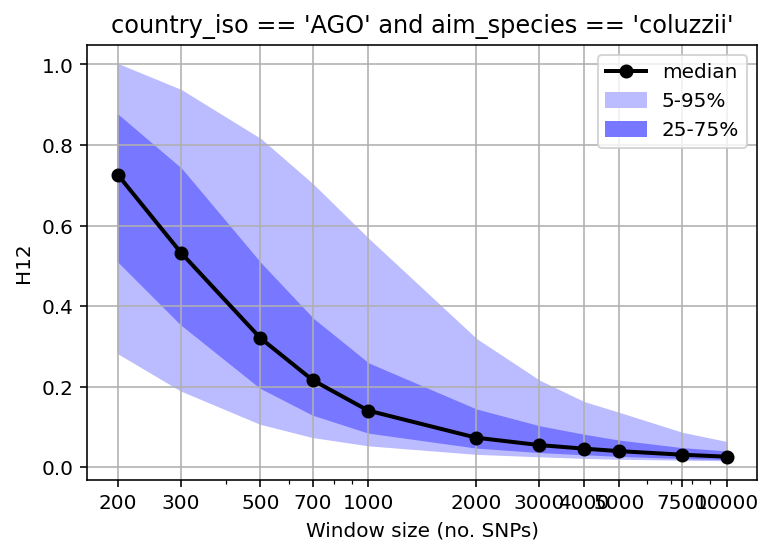

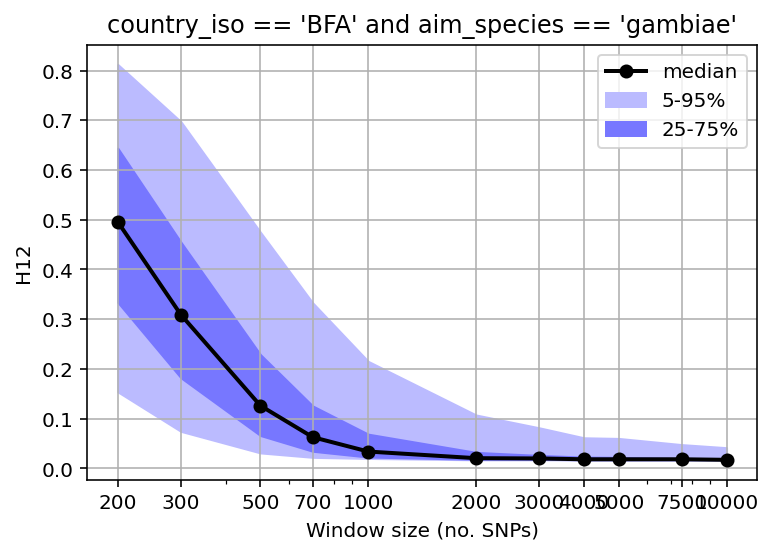

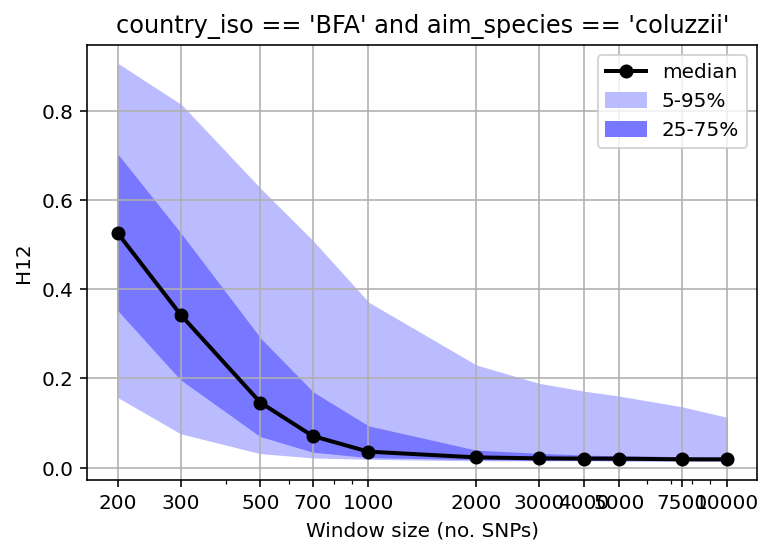

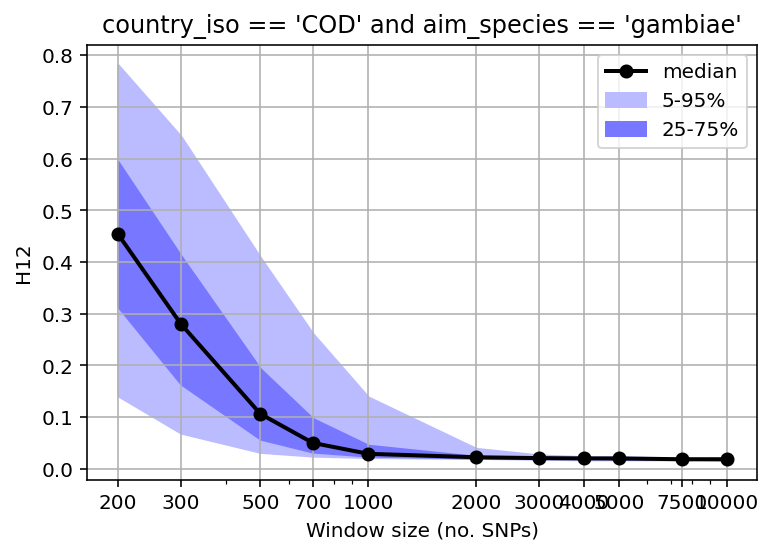

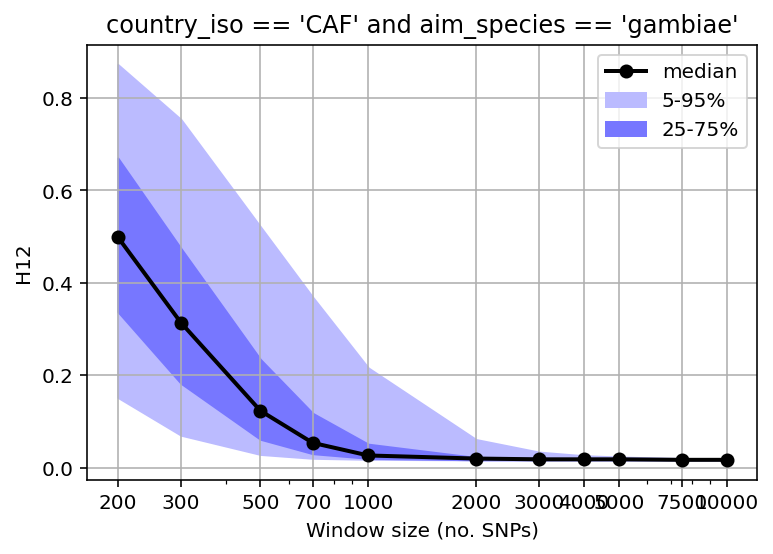

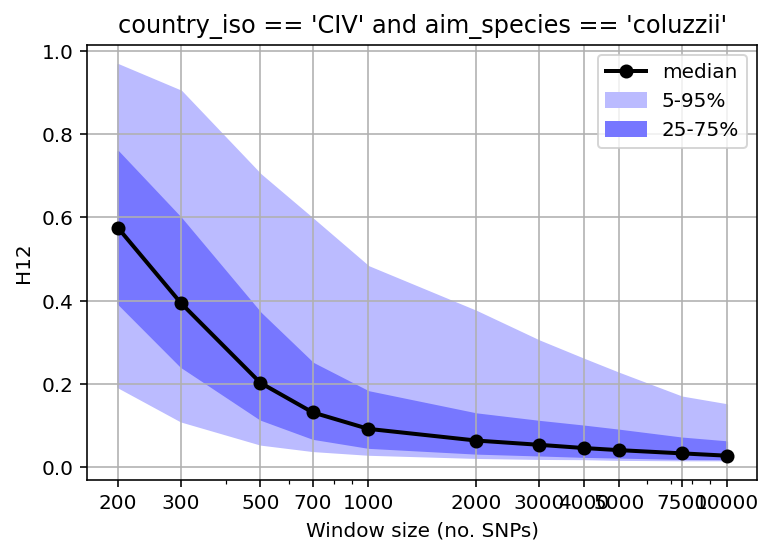

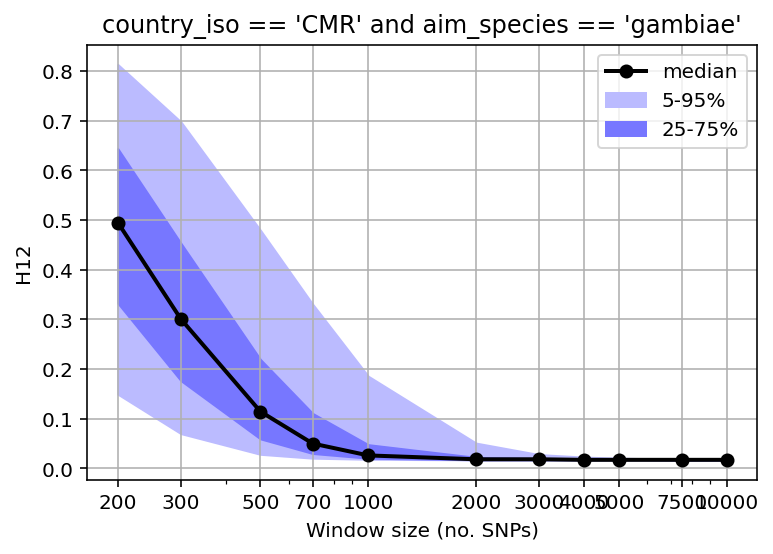

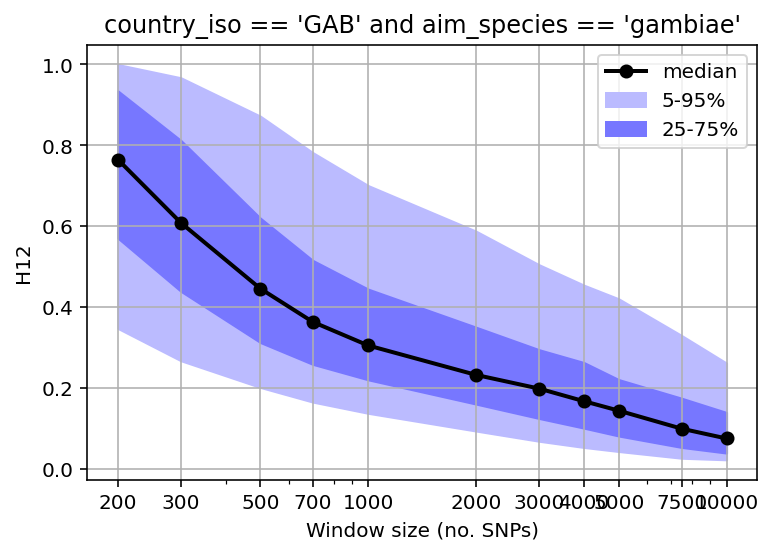

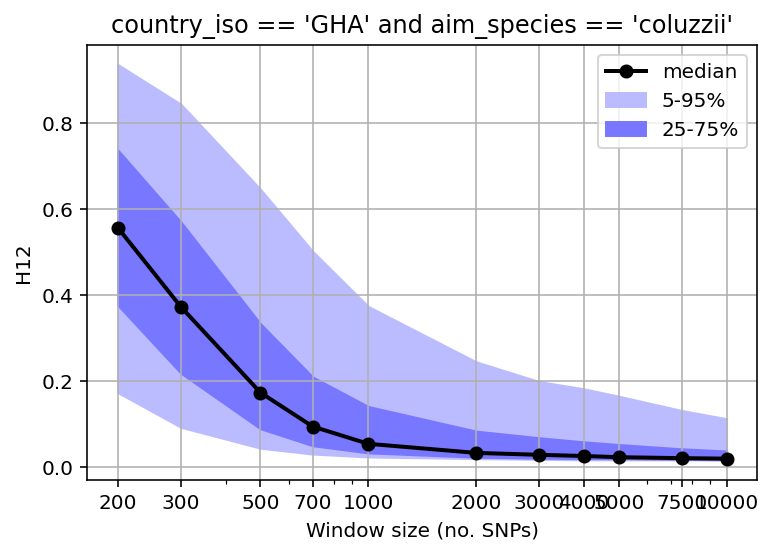

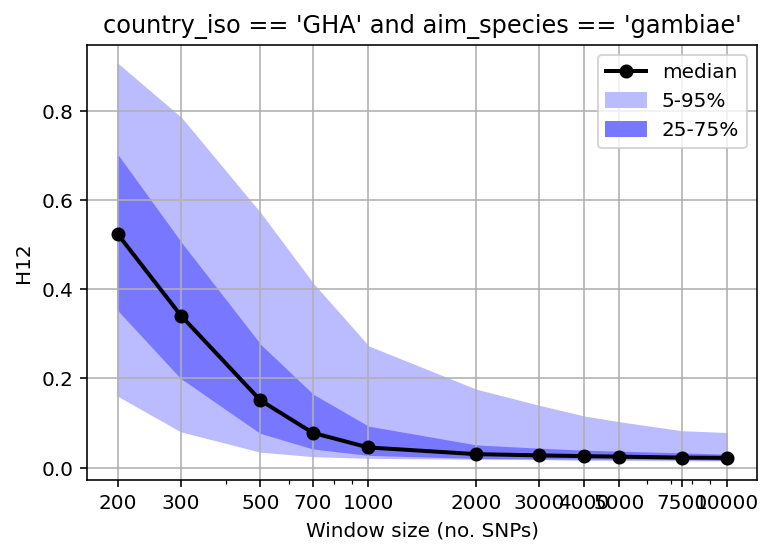

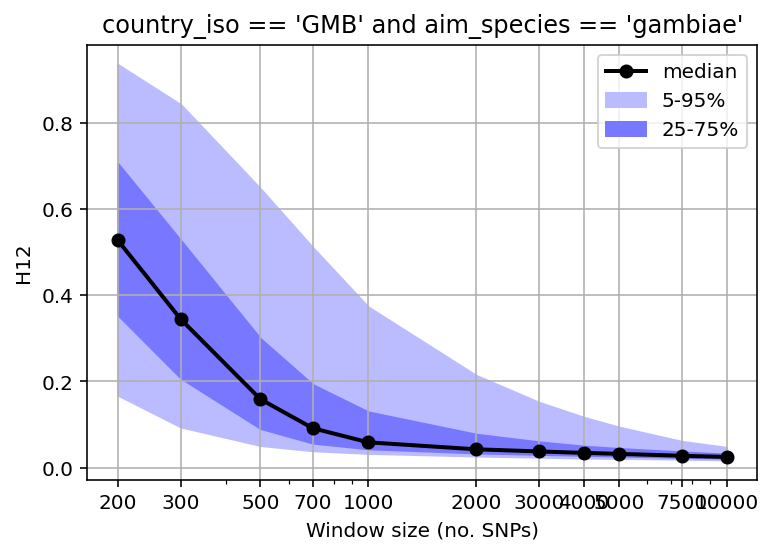

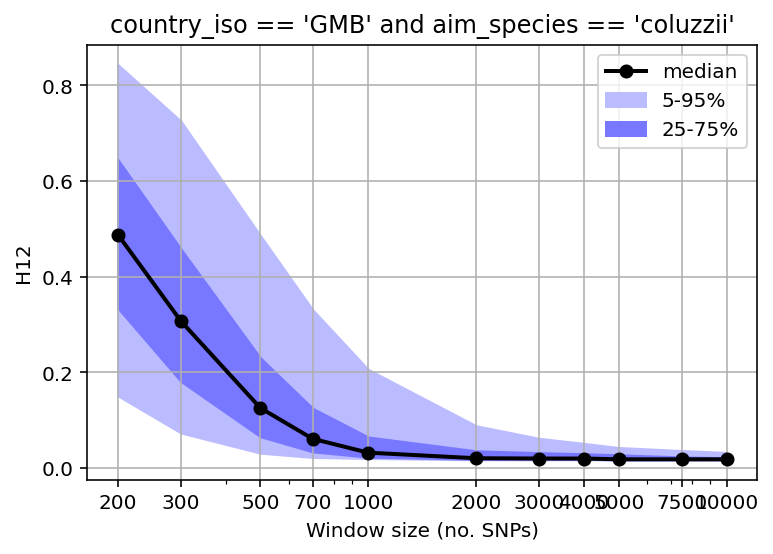

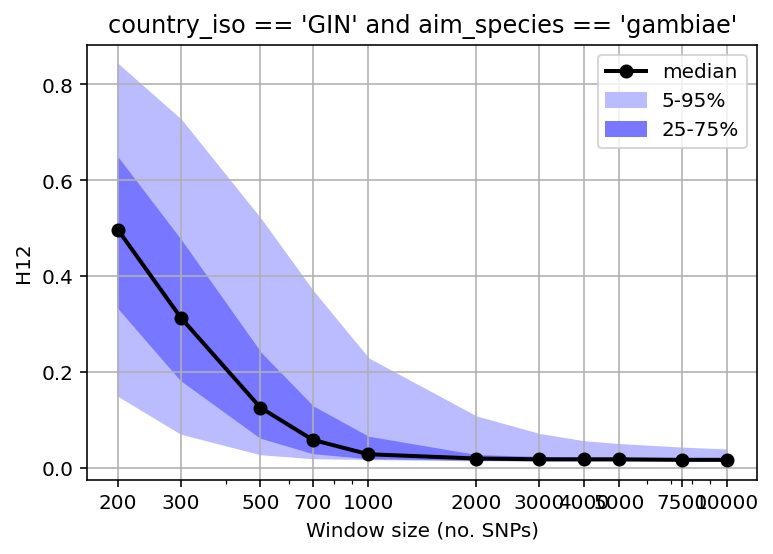

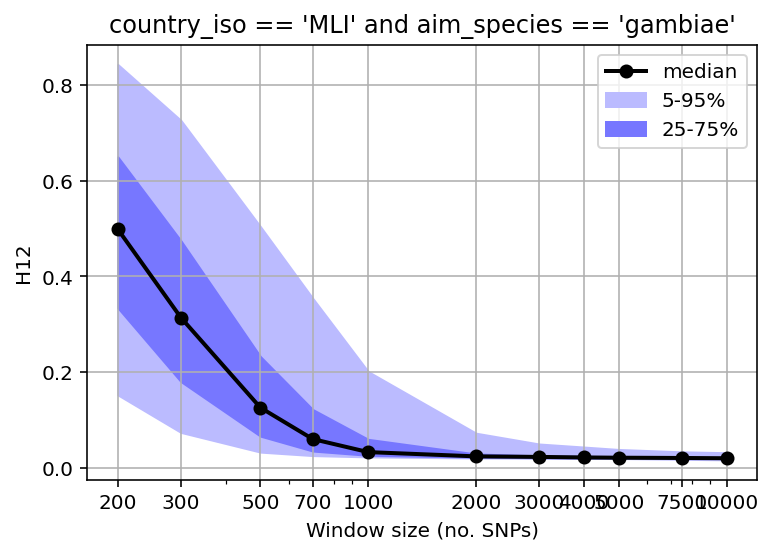

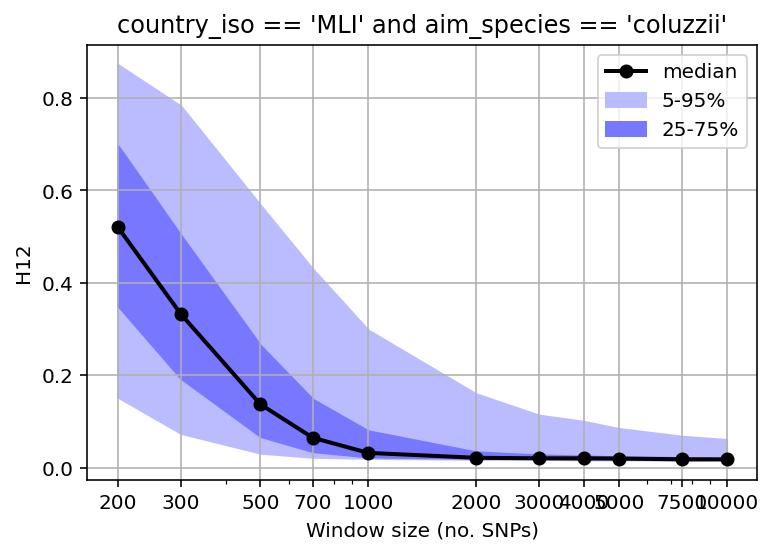

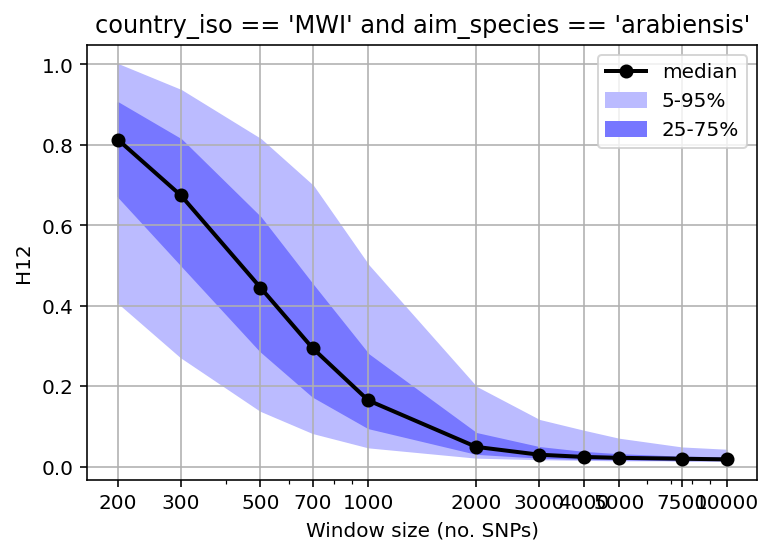

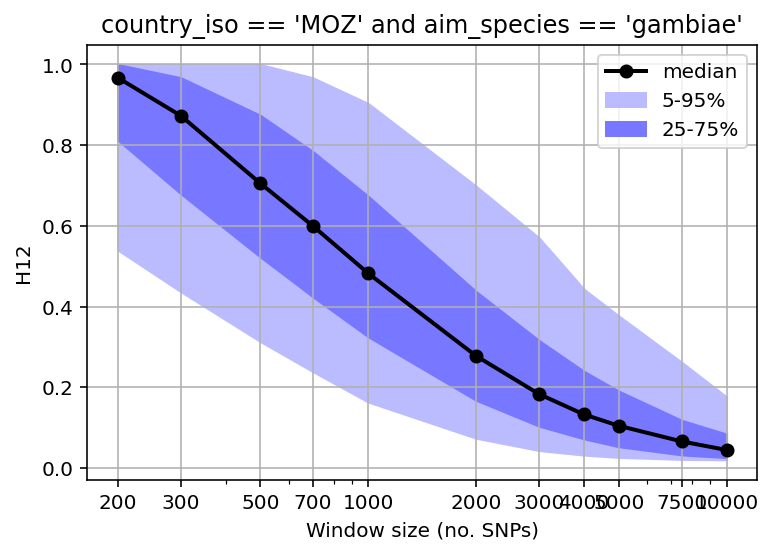

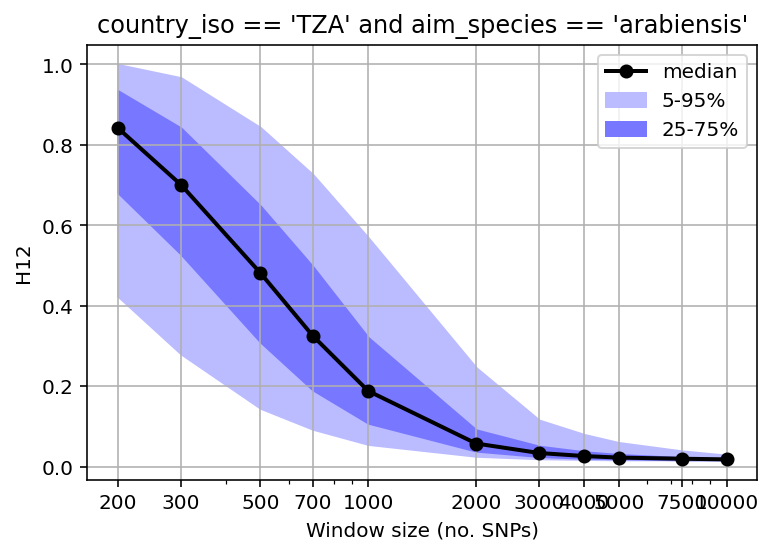

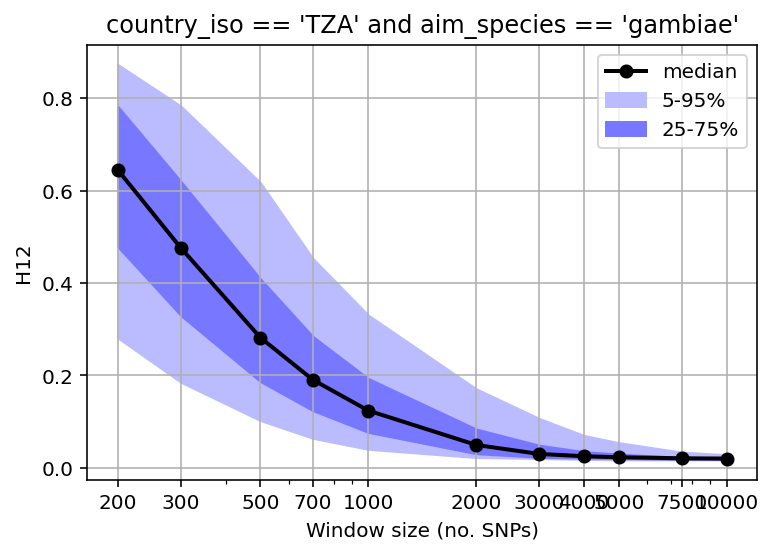

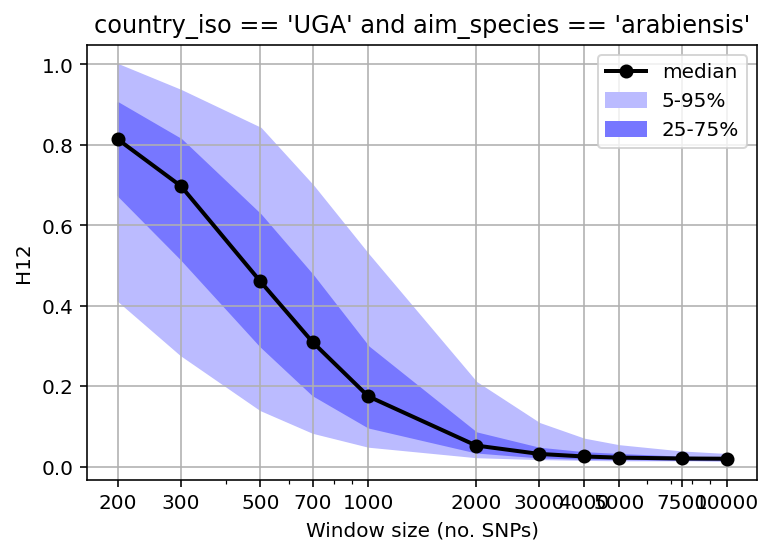

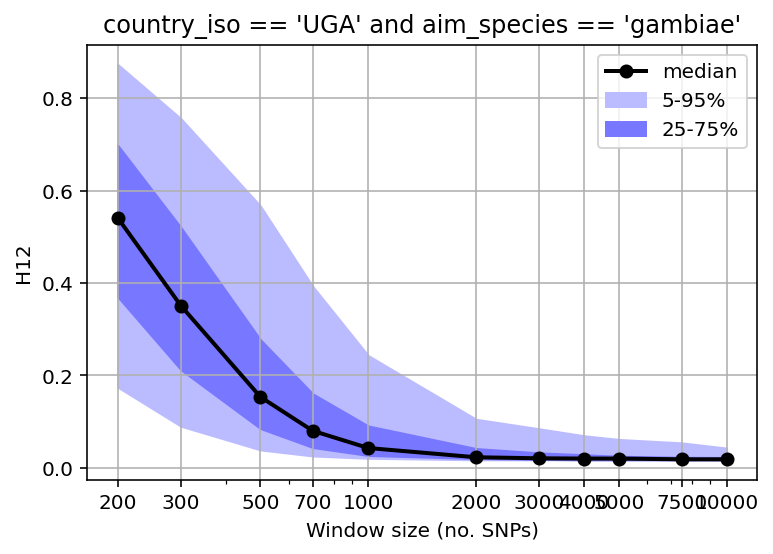

In [ ]:
for key in cohorts.keys():
  window_sizes = (200, 300, 500, 700, 1000, 2000, 3000, 4000, 5000, 7500, 10000)
  plot_h12_calibration(contig="X", analysis="gamb_colu_arab", sample_query=f'{cohorts[key]}',
                       sample_sets="3.0", window_sizes=window_sizes)

In [ ]:
gh12_dict, pos_x = {}, {}
for pop in cohorts.keys():
  pos_x[pop], gh12_dict[pop] = h12_gwss(contig="X", analysis="gamb_colu_arab", sample_query=f'{cohorts[pop]}', 
                                        window_size=4000, sample_sets="3.0", downsample=30, seed=42) 
  

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/324 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/216 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/432 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/216 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/216 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/162 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/270 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/162 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/54 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/216 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/162 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/108 [00:00<?, ?it/s]

Load haplotypes:   0%|          | 0/216 [00:00<?, ?it/s]

In [ ]:
gh12_stat = pd.DataFrame(gh12_dict)
gh12_stat.insert(0, 'pos', pos_x['BFA_coluzzii'])
#gh12_stat

In [ ]:
# Plotting FST
# Compute the figure of sequence divergence 
def fig_h12(x, y, title=None,  ax=None, color=None, ylab=None, xlab=None, 
            annot=None, fig_name=None):
  #define ax 
  if ax is None:
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.despine(ax=ax, offset=5)

  # make plot 
  ax.plot(x, y, linestyle=' ', marker='o', color=color, ms=0.5)
  # Plot title
  if title:
    ax.set_title(f'{title}')
  
  # Customize plot 
  if ylab:
    ax.set_ylabel('Garud H12')
  if xlab:
    ax.set_xlabel('Chrom X (bp)')
  
  #annotations
  if annot:
    ax.axvspan(1283016, 1373662, color='magenta', alpha=0.1, lw=0.3)
    ax.annotate('$fru$ region', xy=(1373662, 0.3), xytext=(1800000, 0.3), color='darkred',
                arrowprops=dict(arrowstyle="->", color='crimson'))
  
  #ax setting 
  ax.set_ylim(0,1)
  xlim=(list(x)[0], list(x)[-1])
  ax.set_xlim(*xlim)
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()]) 
  if fig_name:
    fig.savefig(f"drive/MyDrive/Fru_paper/Fru_graph/H12_{fig_name}.png", dpi=300, bbox_inches='tight')

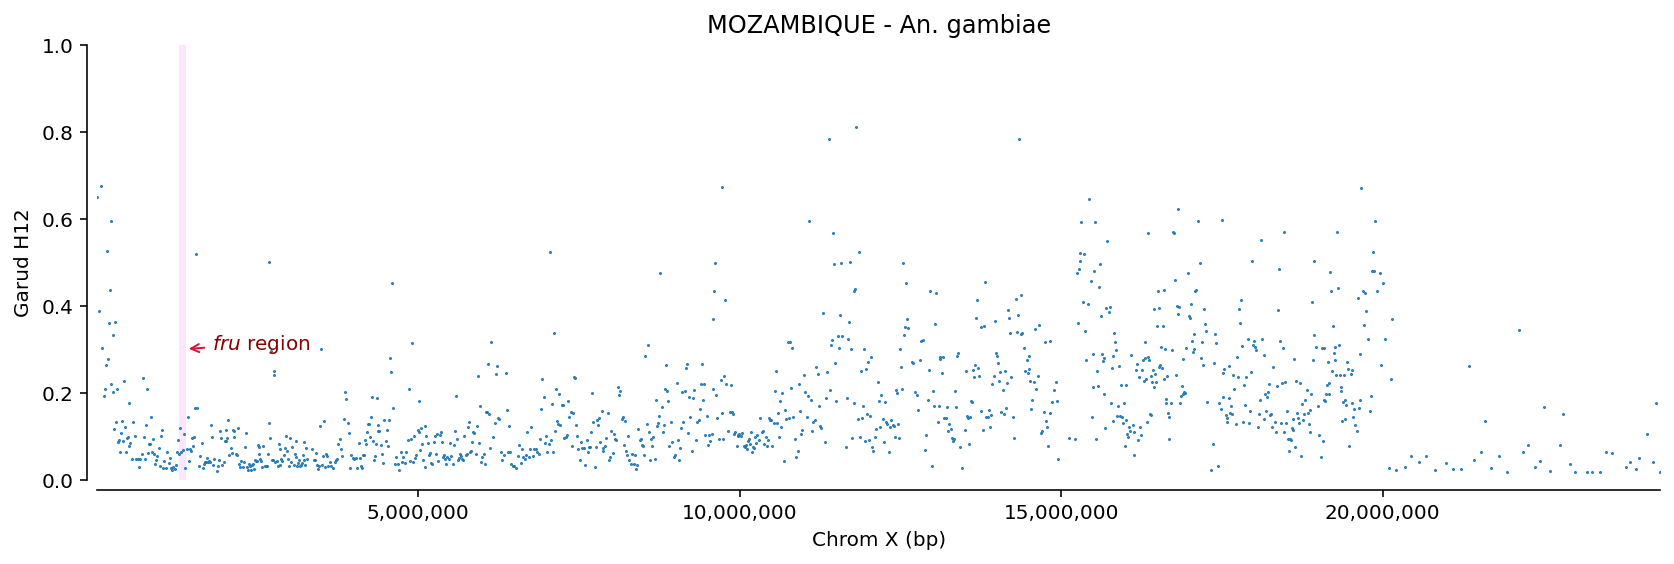

In [ ]:
fig_h12(gh12_stat.pos, gh12_stat.MOZ_gambiae, annot=True, 
        xlab=True, ylab=True, title='MOZAMBIQUE - An. gambiae')

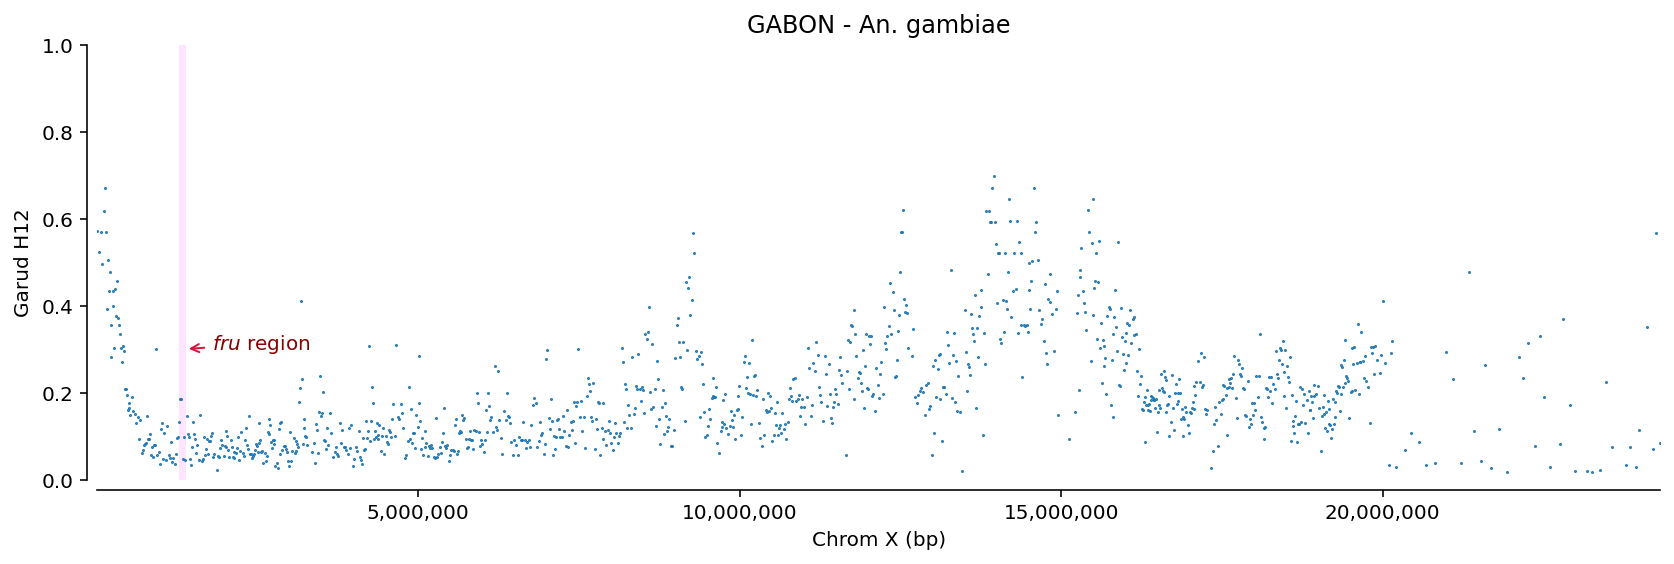

In [ ]:
fig_h12(gh12_stat.pos, gh12_stat.GAB_gambiae, annot=True, 
        xlab=True, ylab=True, title='GABON - An. gambiae')

In [ ]:
#pop_colors
h_colors, label_h, key_list = {}, {}, list(cohorts.keys())
colored = sns.color_palette("husl", len(key_list))
for i in range(len(key_list)):
    h_colors[key_list[i]] = colored[i]
    label_h[key_list[i]] = key_list[i].split('_')[0] + ' (An. ' + key_list[i].split('_')[1] + ')'

# config color
h_color = {'BFA_coluzzii':'gray', 'BFA_gambiae':'mediumorchid', 'CIV_coluzzii':'orangered',
           'GHA_coluzzii':'turquoise', 'GHA_gambiae':'olive', 'GIN_gambiae':'yellowgreen', 
           'GMB_coluzzii':'cyan', 'GMB_gambiae':'darkorange', 'MLI_coluzzii':'crimson',
           'MLI_gambiae':'slategray', 'MOZ_gambiae':'lime', 'MWI_arabiensis':'purple',
           'TZA_arabiensis':'deeppink', 'TZA_gambiae':'red', 'UGA_arabiensis':'dodgerblue', 
           'AGO_coluzzii':'peru', 'CAF_gambiae':'steelblue', 'CMR_gambiae':'gold', 
           'COD_gambiae':'darkviolet', 'GAB_gambiae':'blue', 'UGA_gambiae':'tomato'
           }

In [ ]:
## To remove MOZAMBIQUE and GABON 
list_k = []
for i in key_list:
  if i not in ['MOZ_gambiae', 'GAB_gambiae']:
    list_k.append(i)


## Garud h12 plots in 4kb windows

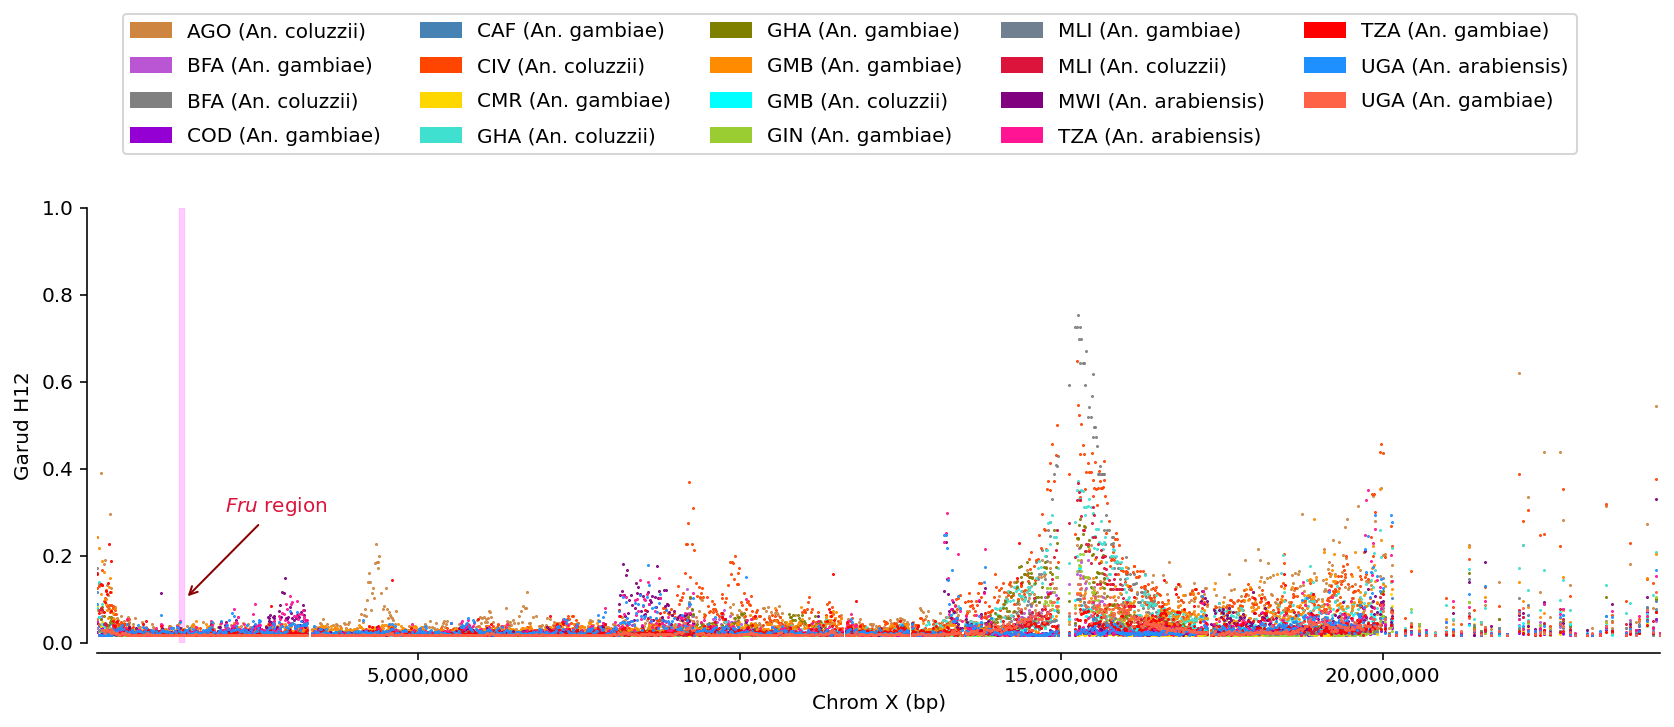

In [ ]:
def plot_h12_all(data, f_list, annot=None, ax=None, title=None, xlab=None, ylab=None, fig_name=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(14,4))
    sns.despine(ax=ax, offset=5)

  #Plot h12
  pos = data[data.columns[0]]
  for idx in f_list:
    h12 = data[idx]
    fig_h12(x=pos, y=h12, ax=ax, color=h_color[idx])
  
    # Plot title
  if title:
    ax.set_title(f'{title}')
  
  # Customize plot 
  if ylab:
    ax.set_ylabel('Garud H12')

  if xlab:
    ax.set_xlabel('Chrom X (bp)')

  # add annotations 
  if annot:
    ax.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.2)
    ax.annotate('$Fru$ region', xy=(1373662, 0.1), xytext=(2000000, 0.3), color='crimson',
            arrowprops=dict(arrowstyle="->", color='darkred'))
  
  #legend
  handles = [mpl.patches.Patch(color=h_color[pop], label=label_h[pop]) for pop in f_list]
  ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.01, 1.1), ncol=5, labelspacing=0.8)

  #Savefig 
  if fig_name:
    fig.savefig(f"drive/MyDrive/Fru_paper/Fru_graph/{fig_name}_gh12.png", dpi=300, bbox_inches='tight')

plot_h12_all(data = gh12_stat, f_list=list_k, annot=True, ax=None, xlab=True, ylab=True, fig_name='fig')

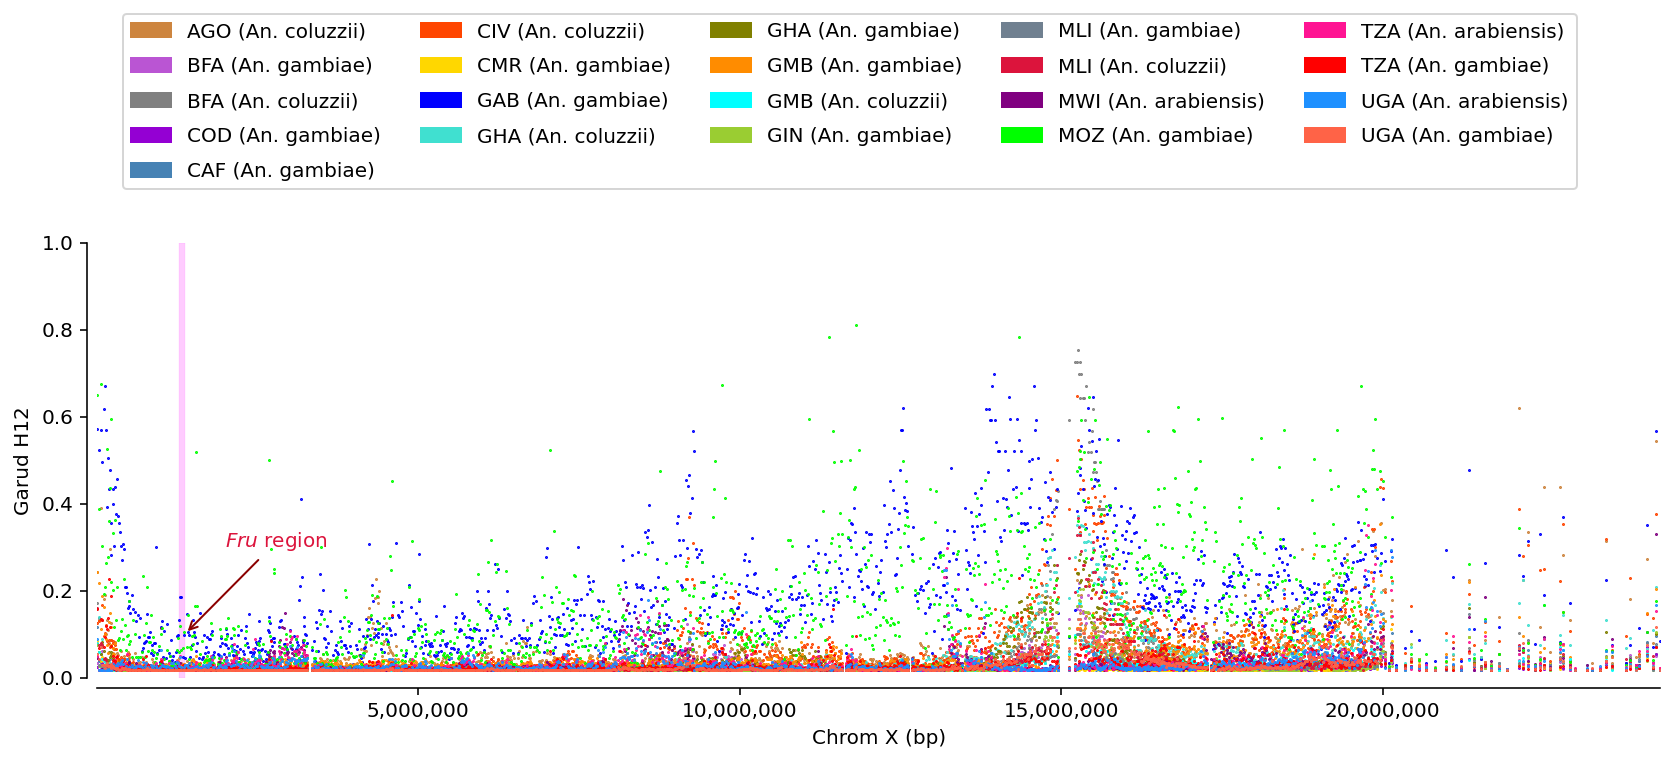

In [79]:
plot_h12_all(data = gh12_stat, f_list=key_list, annot=True, ax=None, xlab=True, ylab=True)

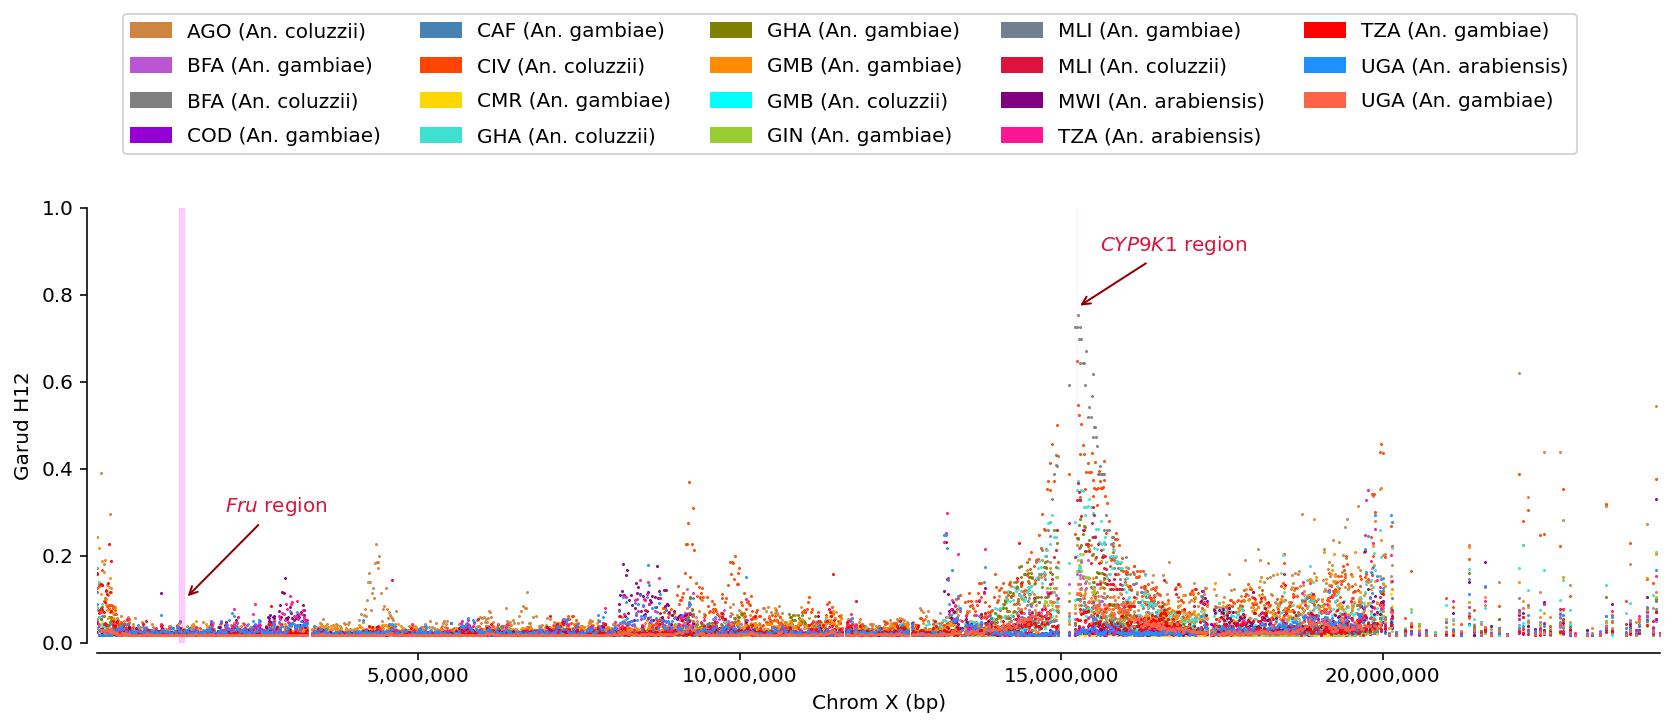

In [ ]:
def plot_h12_all1(data, f_list, annot=None, ax=None, title=None, xlab=None, ylab=None, fig_name=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(14,4))
    sns.despine(ax=ax, offset=5)

  #Plot h12
  pos = data[data.columns[0]]
  for idx in f_list:
    h12 = data[idx]
    fig_h12(x=pos, y=h12, ax=ax, color=h_color[idx])
  
    # Plot title
  if title:
    ax.set_title(f'{title}')
  
  # Customize plot 
  if ylab:
    ax.set_ylabel('Garud H12')

  if xlab:
    ax.set_xlabel('Chrom X (bp)')

  # add annotations 
  if annot:
    ax.axvspan(1283016, 1373662, color='magenta', alpha=0.2, lw=0.2)
    ax.annotate('$Fru$ region', xy=(1373662, 0.1), xytext=(2000000, 0.3), color='crimson',
            arrowprops=dict(arrowstyle="->", color='darkred'))

    ax.axvspan(15240572, 15242864, color='magenta', alpha=0.2, lw=0.2)
    ax.annotate('$CYP9K1$ region', xy=(15242864, 0.77), xytext=(15600000, 0.9), color='crimson',
            arrowprops=dict(arrowstyle="->", color='darkred'))
  
  
  #legend
  handles = [mpl.patches.Patch(color=h_color[pop], label=label_h[pop]) for pop in f_list]
  ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.01, 1.1), ncol=5, labelspacing=0.8)

  #Savefig 
  if fig_name:
    fig.savefig(f"drive/MyDrive/Fru_paper/Fru_graph/{fig_name}_gh12.png", dpi=300, bbox_inches='tight')

plot_h12_all1(data = gh12_stat, f_list=list_k, annot=True, ax=None, xlab=True, ylab=True, fig_name='fig1')

In [46]:
gh12_stat1 = gh12_stat.drop(['MOZ_gambiae', 'GAB_gambiae'], axis=1)

In [49]:
resum = gh12_stat1.query('pos > 1283016 and pos < 1373662').describe().transpose()
resum

,count,mean,std,min,25%,50%,75%,max
pos,5.0,1.321950e+06,29715.409879,1.288147e+06,1.302824e+06,1.316350e+06,1.339399e+06,1.363032e+06
AGO_coluzzii,5.0,3.277778e-02,0.007827,2.277778e-02,3.055556e-02,3.166667e-02,3.444444e-02,4.444444e-02
BFA_gambiae,5.0,1.722222e-02,0.000000,1.722222e-02,1.722222e-02,1.722222e-02,1.722222e-02,1.722222e-02
BFA_coluzzii,5.0,1.811111e-02,0.000497,1.722222e-02,1.833333e-02,1.833333e-02,1.833333e-02,1.833333e-02
COD_gambiae,5.0,2.066667e-02,0.000913,2.000000e-02,2.000000e-02,2.055556e-02,2.055556e-02,2.222222e-02
CAF_gambiae,5.0,1.722222e-02,0.000000,1.722222e-02,1.722222e-02,1.722222e-02,1.722222e-02,1.722222e-02
CIV_coluzzii,5.0,2.055556e-02,0.002187,1.722222e-02,2.000000e-02,2.055556e-02,2.222222e-02,2.277778e-02
CMR_gambiae,5.0,1.722222e-02,0.000000,1.722222e-02,1.722222e-02,1.722222e-02,1.722222e-02,1.722222e-02
GHA_coluzzii,5.0,1.822222e-02,0.001139,1.722222e-02,1.722222e-02,1.833333e-02,1.833333e-02,2.000000e-02
GHA_gambiae,5.0,1.977778e-02,0.001394,1.833333e-02,1.833333e-02,2.000000e-02,2.111111e-02,2.111111e-02


In [66]:
resum.iloc[1:,].describe()

,count,mean,std,min,25%,50%,75%,max
count,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,5.0,0.021234,0.003046,0.018246,0.019854,0.020468,0.021696,0.025906
std,0.0,0.004522,0.004037,0.001607,0.003670,0.003832,0.005049,0.010727
min,5.0,0.017222,0.000000,0.017222,0.017222,0.017222,0.017222,0.017222
25%,5.0,0.017667,0.000497,0.017222,0.017222,0.017778,0.017778,0.018333
50%,5.0,0.020111,0.001139,0.017222,0.018333,0.020000,0.020556,0.021111
75%,5.0,0.022222,0.004084,0.018333,0.020278,0.020833,0.023333,0.030000
max,5.0,0.032778,0.013173,0.022778,0.030556,0.031667,0.034444,0.049444


In [77]:
resum1 = gh12_stat.query('pos >  14000000 and pos < 16000000').describe().transpose()
resum1

,count,mean,std,min,25%,50%,75%,max
pos,101.0,1.504562e+07,627310.523487,1.401690e+07,1.447937e+07,1.512888e+07,1.562017e+07,1.598860e+07
AGO_coluzzii,101.0,1.065952e-01,0.042467,3.055556e-02,7.388889e-02,1.033333e-01,1.311111e-01,2.372222e-01
BFA_gambiae,101.0,7.647965e-02,0.043343,2.222222e-02,4.277778e-02,6.166667e-02,1.038889e-01,2.166667e-01
BFA_coluzzii,101.0,2.633938e-01,0.212604,2.888889e-02,8.555556e-02,1.866667e-01,4.072222e-01,7.533333e-01
COD_gambiae,101.0,2.192519e-02,0.002094,1.722222e-02,2.055556e-02,2.222222e-02,2.277778e-02,2.944444e-02
CAF_gambiae,101.0,2.100660e-02,0.003554,1.722222e-02,1.833333e-02,2.000000e-02,2.111111e-02,3.333333e-02
CIV_coluzzii,101.0,2.569197e-01,0.130406,7.555556e-02,1.394444e-01,2.216667e-01,3.588889e-01,6.466667e-01
CMR_gambiae,101.0,1.952695e-02,0.001960,1.722222e-02,1.833333e-02,2.000000e-02,2.000000e-02,2.666667e-02
GAB_gambiae,101.0,3.930473e-01,0.121090,9.222222e-02,3.183333e-01,3.894444e-01,4.738889e-01,6.716667e-01
GHA_coluzzii,101.0,1.895325e-01,0.081550,5.055556e-02,1.211111e-01,1.844444e-01,2.438889e-01,3.716667e-01


In [78]:
resum1.iloc[1:,].describe()

,count,mean,std,min,25%,50%,75%,max
count,21.0,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,101.0,0.110406,0.054508,0.030132,0.067937,0.098995,0.143439,0.271720
std,0.0,0.105968,0.056320,0.020349,0.071461,0.098201,0.142333,0.243190
min,101.0,0.019527,0.001960,0.017222,0.018333,0.020000,0.020000,0.026667
25%,101.0,0.024807,0.010760,0.017222,0.020556,0.022222,0.026111,0.092778
50%,101.0,0.067629,0.039395,0.022222,0.042778,0.055000,0.085000,0.215000
75%,101.0,0.133713,0.081550,0.030556,0.085556,0.127222,0.197222,0.366667
max,101.0,0.393047,0.212604,0.092222,0.318333,0.389444,0.473889,0.782778
